## <center>**Evaluation**<center/>

In [1]:
import pandas as pd
import numpy as np
import warnings
import gc
import os 
import sys
from IPython.core.interactiveshell import  InteractiveShell
pd.set_option('max.rows',200)
pd.set_option('max.columns',100)
warnings.filterwarnings('ignore')
InteractiveShell.ast_node_interactivity = "all"

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
sns.mpl.rcParams['figure.figsize'] = (8.0, 4.0)

# display Chinese in pictures
from matplotlib.font_manager import FontProperties
myfont=FontProperties(fname=r'C:\Windows\Fonts\simhei.ttf',size=15)
sns.set(font=myfont.get_name())

In [3]:
from numba import njit

#### **data**

In [4]:
data = pd.read_pickle('data')
date_list = data.index.tolist()

In [5]:
import json 
# match result 
match_by_matrix = json.load(open('..\\match_result\\match_by_matrix.json'))     
match_by_industry = json.load(open('..\\match_result\\match_by_matrix.json'))       

### **Ⅰ match by matrix direction evaluation**     

#### **1. example plot**

end of plot
Wall time: 44.6 s


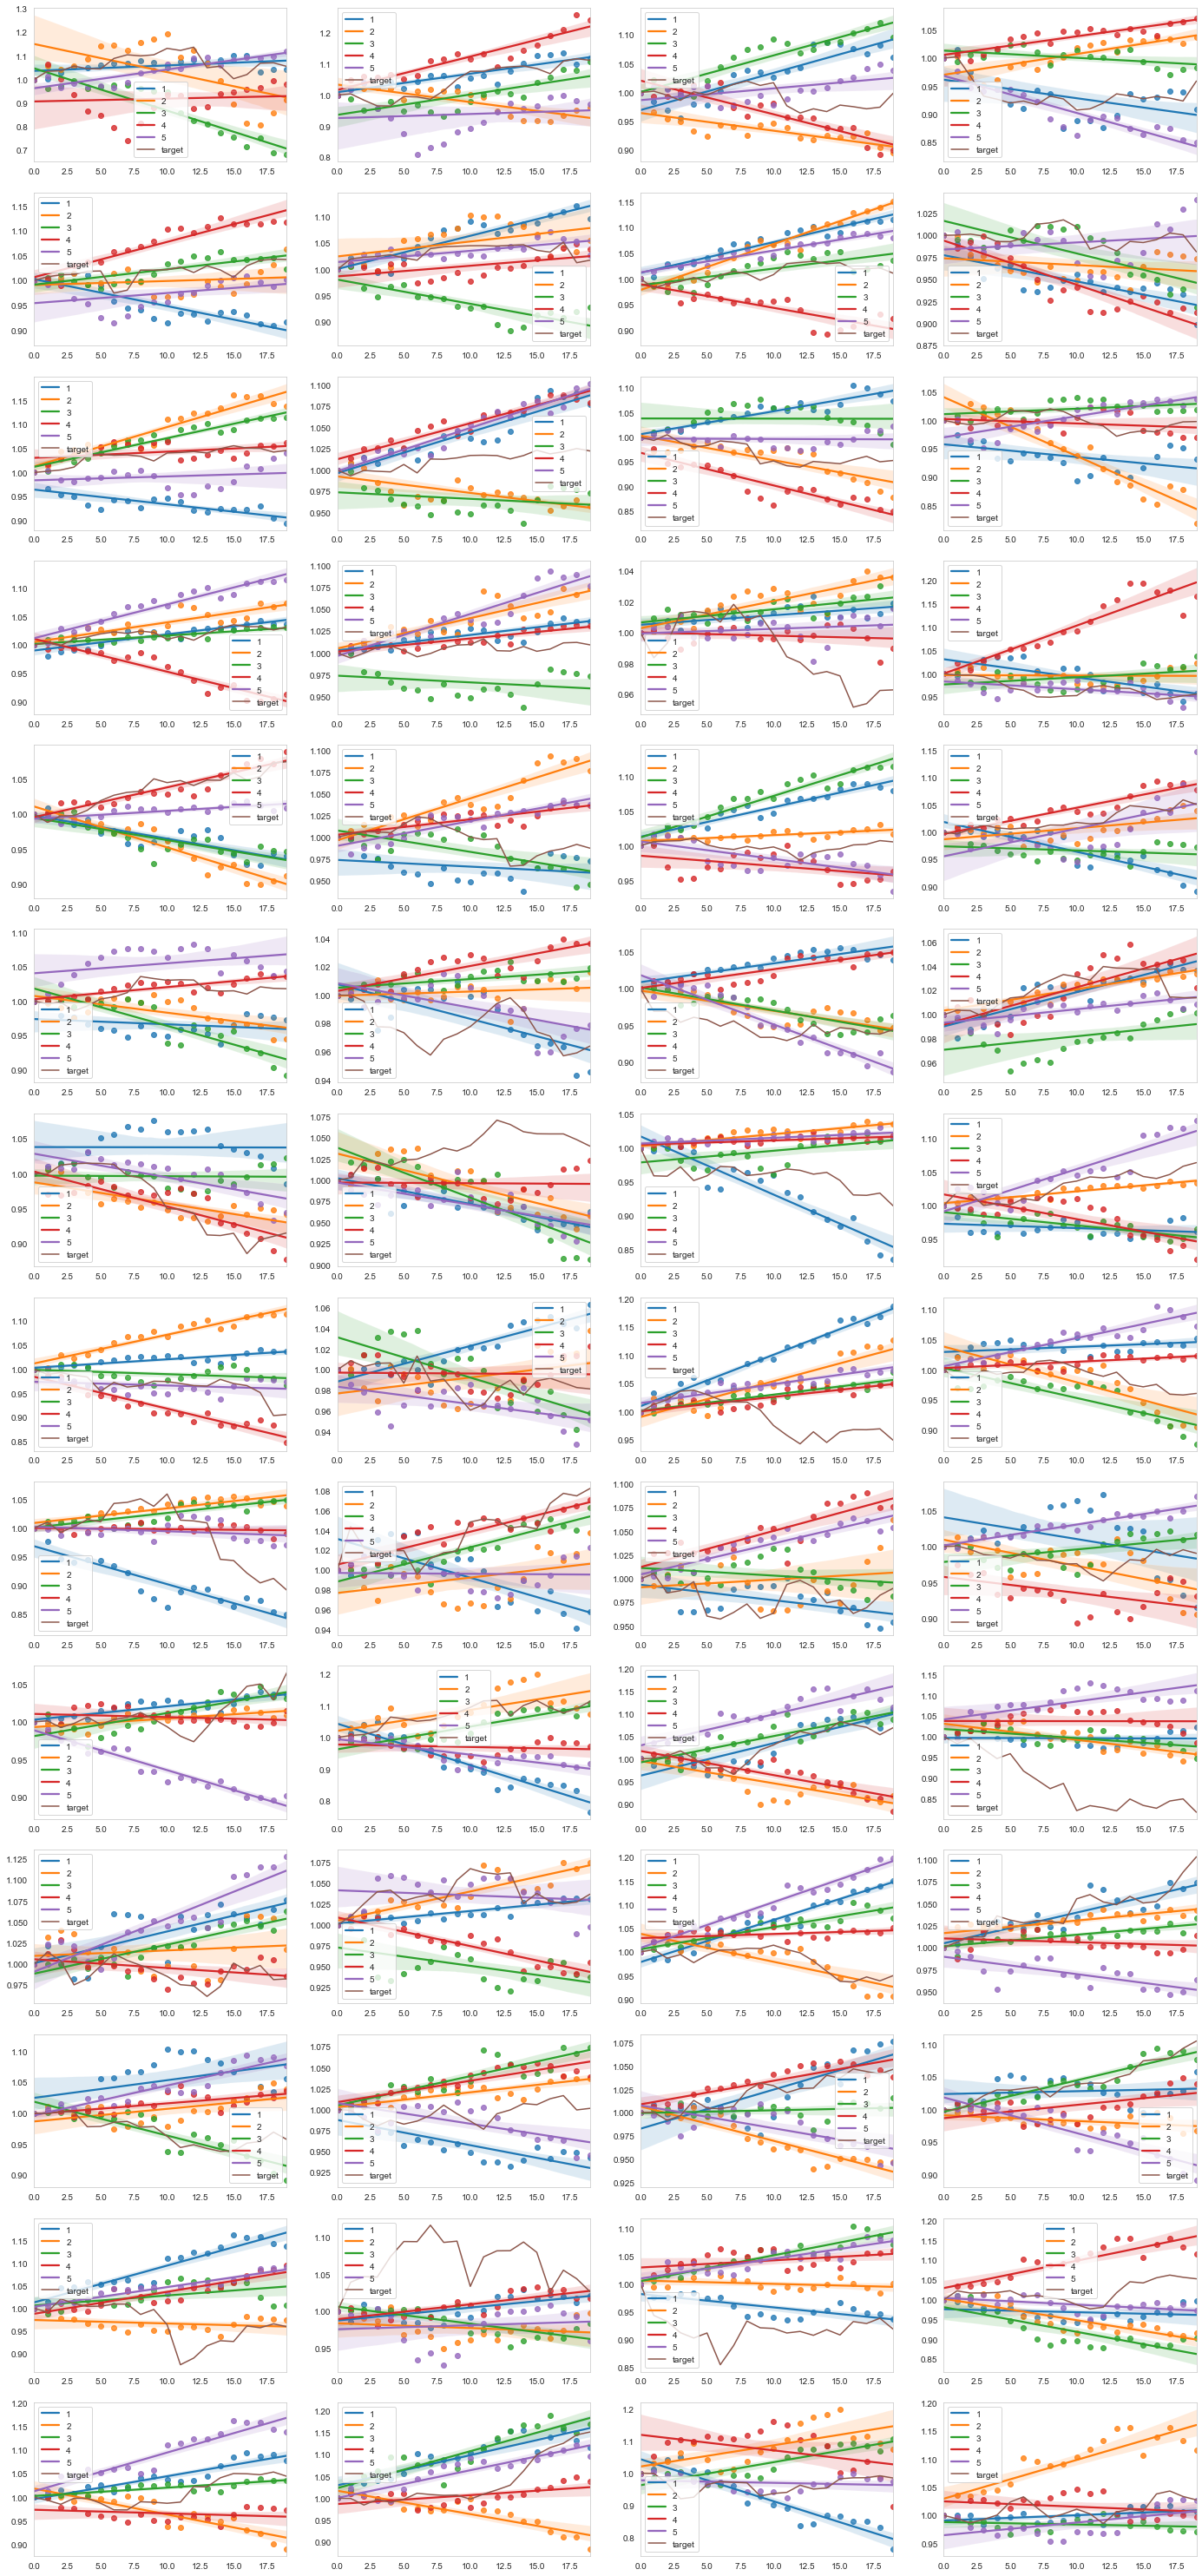

In [6]:
%%time
selected_col = '汽车'

fig, axes = plt.subplots(14,4,figsize=(24,54))

for count,date in enumerate(list(match_by_matrix.keys())[:56]):
    daily_match = match_by_matrix[date]
    matched_start_date = [item[0] for item in daily_match]
    matched_data_list = [data[start_date:].iloc[20:40,:][selected_col] for start_date in matched_start_date[:5]]
    # normalize 
    matched_data_list = [value/value.iloc[0] for value in matched_data_list]
    # target data 
    target = data[date:].iloc[20:40][selected_col]
    target /= target.iloc[0]
    
    for i in range(5):
        x = np.arange(0,20,1)
        sns.regplot(x, matched_data_list[i].values, ax=axes[(count//4,count%4)])
    axes[(count//4,count%4)].plot(target.values)
    axes[(count//4,count%4)].legend(['1','2','3','4','5','target'])
print('end of plot');

#### **2. direction**        

In [7]:
# linear regression 
import statsmodels.api as sm

def cal_slope(y:'array like'):
    x = np.arange(0,20,1)
    x = sm.add_constant(x)
    model = sm.OLS(y,x)
    fit_result = model.fit()
    return fit_result.params[1]

In [14]:
%%time 
direct_acc = np.zeros(shape=(56,28)) 

for col_i, selected_col in enumerate(data.columns):
    
    for date_i, date in enumerate(list(match_by_matrix)[:56]):
        matched_start_date = [item[0] for item in match_by_matrix[date]]
        matched_data_list = [data[start_date:].iloc[20:40,:][selected_col] for start_date in matched_start_date[:5]]
        # target data 
        target = data[date:].iloc[20:40][selected_col]
        # linear regression 
        matched_data_slope_list = [1 if cal_slope(value.values)>0 else -1 for value in matched_data_list]
        matched_data_slope = 1 if sum(matched_data_slope_list)>0 else -1 
        target_slope = 1 if cal_slope(target.values)>0 else -1
        if target_slope == matched_data_slope: 
            direct_acc[date_i][col_i] = 1   

direct_acc = pd.DataFrame(direct_acc, columns=data.columns, index=list(match_by_matrix)[:56])

Wall time: 6.11 s


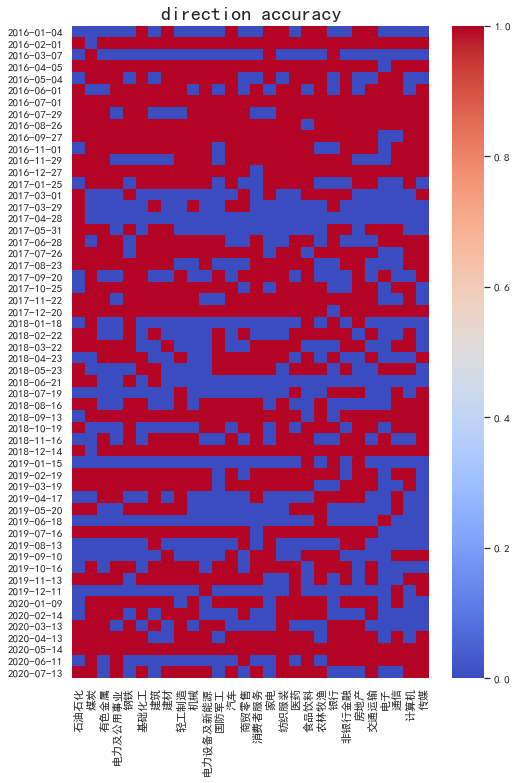

In [25]:
plt.figure(figsize=(8,12))
sns.heatmap(direct_acc,cmap='coolwarm')
plt.title('direction accuracy',size=20);

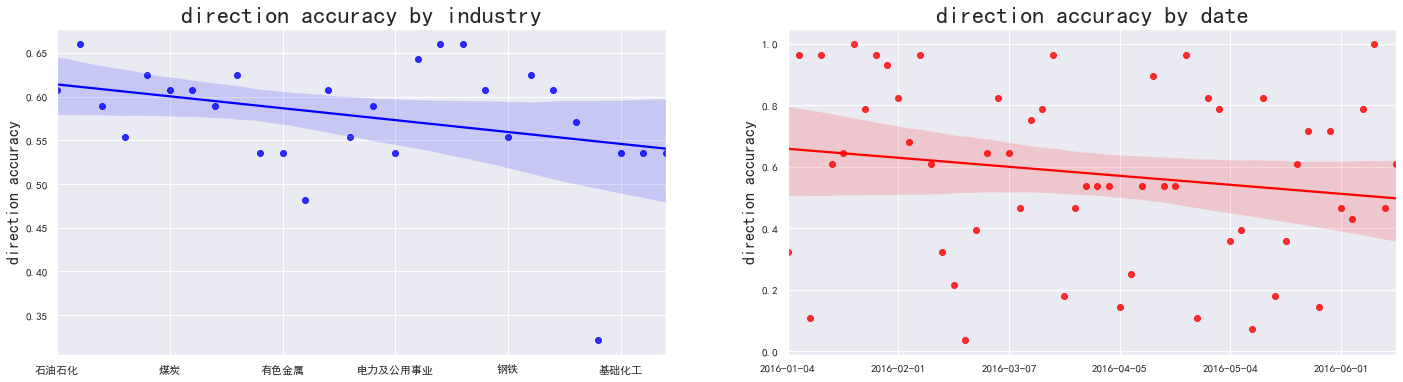

In [37]:
fig, axes = plt.subplots(1,2,figsize=(24,6))
direct_acc_by_industry = direct_acc.sum()/direct_acc.shape[0]
direct_acc_by_date = direct_acc.sum(1)/direct_acc.shape[1]
x1 = np.arange(0,len(direct_acc_by_industry),1)
x2 = np.arange(0,len(direct_acc_by_date),1)
sns.regplot(x1, direct_acc_by_industry.values, ax=axes[0], color='blue')
sns.regplot(x2, direct_acc_by_date.values, ax=axes[1], color='red')
axes[0].set_title('direction accuracy by industry',size=24)
axes[0].set_xticklabels(direct_acc_by_industry.index)
axes[0].set_ylabel('direction accuracy',fontsize=16)
axes[1].set_title('direction accuracy by date',size=24)
axes[1].set_xticklabels(direct_acc_by_date.index)
axes[1].set_ylabel('direction accuracy',fontsize=16);

### **Ⅱ match by industry evaluation**     

In [20]:
%%time
accuracy = []
for selected_col in data.columns:
    flag = 0
    
    for date in list(match_by_industry.keys())[:56]:
        matched_start_date_value = match_by_industry[date][selected_col]
        matched_start_date = [item[0] for item in matched_start_date]
        matched_data_list = [data[start_date:].iloc[20:40,:][selected_col] for start_date in matched_start_date[:5]]
        # target data 
        target = data[date:].iloc[20:40][selected_col]
        # linear regression 
        matched_data_slope_list = [1 if cal_slope(value.values)>0 else -1 for value in matched_data_list]
        matched_data_slope = 1 if sum(matched_data_slope_list)>0 else -1 
        target_slope = 1 if cal_slope(target.values)>0 else -1
        if target_slope == matched_data_slope: 
            flag += 1 
    accuracy.append(flag/56)
    print(flag/56)

0.5357142857142857
0.5357142857142857
0.48214285714285715
0.5178571428571429
0.4642857142857143
0.5535714285714286
0.5
0.5892857142857143
0.5357142857142857
0.5
0.5178571428571429
0.5
0.5357142857142857
0.5
0.5892857142857143
0.5714285714285714
0.42857142857142855
0.625
0.7321428571428571
0.625
0.5178571428571429
0.5535714285714286
0.48214285714285715
0.5357142857142857
0.5357142857142857
0.5
0.48214285714285715
0.39285714285714285
Wall time: 6.52 s
